# 25 - Doubles Différences Synthétiques

Dans les chapitres précédents, nous avons examiné à la fois les méthodes de Doubles Différences et de Contrôle Synthétique pour identifier l'effet du traitement avec des données de panel (données où nous avons plusieurs unités observées sur plusieurs périodes). Il se trouve que nous pouvons fusionner les deux approches en un seul estimateur. Cette nouvelle procédure d'estimation Synthetic Difference-in-Differences parvient à exploiter les avantages des deux méthodes tout en augmentant la précision (réduisant les marges d'erreur) de l'estimation de l'effet du traitement.

Nous allons discuter principalement des Doubles Différences Synthétiques dans le cas d'une **attribution de traitement par blocs**. Cela signifie que nous observons plusieurs unités au fil du temps et que, **au même moment**, certaines unités sont traitées tandis que d'autres restent non traitées. Nous pouvons visualiser cela par une matrice d'attribution de traitement $D$, où les **colonnes de la matrice sont les unités** et les **lignes de la matrice sont les périodes de temps**.

$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 1 & 1 \\
    0 & 0 & 0 & \dots & 1 & 1 \\
\end{bmatrix}
$$

Pour rendre les choses plus concrètes, suivons l'exemple de l'estimation de l'impact de la Proposition 99 sur la consommation de cigarettes en Californie. Dans ce cas, nous n'avons qu'une unité traitée, la Californie, qui reçoit le traitement (adoption de la Proposition 99) à un moment donné (novembre 1988, pour être précis). Si nous disons que la Californie est la dernière colonne de la matrice, nous obtenons quelque chose comme ceci :

$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 0 & 1 \\
    0 & 0 & 0 & \dots & 0 & 1 \\
\end{bmatrix}
$$

Notez qu'ici, nous parlons uniquement du cas où toutes les unités traitées reçoivent le traitement **au même moment**. À la fin, nous discuterons de la manière de gérer l'**attribution de traitement par adoption échelonnée**, où le traitement est déployé progressivement aux unités, les amenant à le recevoir à différents moments. La seule chose que nous exigerons dans cette conception est qu'une fois qu'une unité est traitée, elle ne redevient pas non traitée.

Revenons au cas simple, où toutes les unités sont traitées en même temps, nous pouvons simplifier la matrice d'attribution de traitement en quatre blocs, chacun représenté par une autre matrice. En général, en descendant dans la matrice, nous avançons dans le temps. Nous regrouperons également les unités traitées à droite de la matrice. Par conséquent, le premier bloc de notre matrice (en haut à gauche) correspond aux unités de contrôle avant la période de traitement ; le deuxième bloc (en haut à droite) correspond aux unités traitées avant la période de traitement ; le troisième bloc (en bas à gauche) contient les unités de contrôle après la période de traitement et le quatrième bloc (en bas à droite) correspond aux unités traitées après la période de traitement. L'indicateur de traitement est nul partout, sauf pour le bloc contenant les unités traitées après la période de traitement.

$$
D = \begin{bmatrix}
    \pmb{0} & \pmb{0} \\
    \pmb{0} & \pmb{1} \\
\end{bmatrix}
$$

Cette matrice d'attribution conduira à la matrice de résultats suivante :

$$
Y = \begin{bmatrix}
    \pmb{Y}_{pre, co} & \pmb{Y}_{pre, tr} \\
    \pmb{Y}_{post, co} & \pmb{Y}_{post, tr} \\
\end{bmatrix}
$$

Encore une fois, remarquez comment la période post-traitement est en bas et les unités traitées sont à droite.

Dans notre exemple d'estimation de l'effet de la Proposition 99, le résultat $Y$ est la vente de cigarettes. Nous utilisons $pre$ et $post$ pour représenter respectivement la période avant et après le traitement, et $co$ et $tr$ pour représenter respectivement l'unité de contrôle et l'unité traitée.

Nous utiliserons cette représentation matricielle chaque fois que nous parlerons de l'estimation des pondérations du contrôle synthétique, mais il existe également une autre représentation des données qui est utile, surtout si nous parlons de DiD. Dans cette représentation, nous avons un tableau avec 5 colonnes : une représentant les unités, une représentant les périodes de temps, une colonne de résultats, et deux colonnes booléennes indiquant les unités traitées et la période de traitement. Le nombre de lignes de ce tableau est le nombre d'unités $N$ multiplié par le nombre de périodes $T$. Voici à quoi cela ressemble pour les données de la Proposition 99 :

In [1]:
import numpy as np
import pandas as pd
from toolz import curry, partial
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use("ggplot")

pd.set_option('display.max_columns', 10)

In [2]:
data = (pd.read_csv("data/smoking.csv")[["state", "year", "cigsale", "california", "after_treatment"]]
        .rename(columns={"california": "treated"})
        .replace({"state": {3: "california"}}))

data.head()

,state,year,cigsale,treated,after_treatment
0,1,1970,89.800003,False,False
1,1,1971,95.400002,False,False
2,1,1972,101.099998,False,False
3,1,1973,102.900002,False,False
4,1,1974,108.199997,False,False


In [3]:
data.query("state=='california'").query("year.between(1986, 1990)")

,state,year,cigsale,treated,after_treatment
78,california,1986,99.699997,True,False
79,california,1987,97.500000,True,False
80,california,1988,90.099998,True,False
81,california,1989,82.400002,True,True
82,california,1990,77.800003,True,True


Si nous voulons passer de ce tableau à la représentation matricielle que nous avons discutée plus tôt, il suffit de faire pivoter le tableau par temps (année) et par unité (état). Nous alternerons entre ces deux représentations, car l'une est plus pratique pour le DiD et l'autre pour l'estimation des Contrôles Synthétiques.

In [4]:
data_piv = data.pivot("year", "state", "cigsale")
data_piv = data_piv.rename(columns={c: f"state_{c}" for c in data_piv.columns if c != "california"})

data_piv.head()[["state_1", "state_2", "state_4", "state_38", "state_39", "california"]].round()

state,state_1,state_2,state_4,state_38,state_39,california
year,,,,,,
1970,90.0,100.0,125.0,106.0,132.0,123.0
1971,95.0,104.0,126.0,105.0,132.0,121.0
1972,101.0,104.0,134.0,109.0,140.0,124.0
1973,103.0,108.0,138.0,110.0,141.0,124.0
1974,108.0,110.0,133.0,112.0,146.0,127.0


En termes de résultats potentiels, nous pouvons revenir à la matrice des résultats pour examiner l'objectif d'inférence causale ici. Puisque le traitement n'est appliqué à l'unité traitée qu'après la période de traitement, nous observons le résultat potentiel $Y_0$ partout dans la matrice, sauf pour le bloc en bas à droite.

$$
Y = \begin{bmatrix}
    \pmb{Y}(0)_{pre, co} & \pmb{Y}(0)_{pre, tr} \\
    \pmb{Y}(0)_{post, co} & \pmb{Y}(1)_{post, tr} \\
\end{bmatrix}
$$

Notre objectif est d'estimer le $ATT =  \pmb{Y}(1)_{post, tr} -  \pmb{Y}(0)_{post, tr}$. Pour cela, nous devons d'une manière ou d'une autre estimer le résultat potentiel manquant $\pmb{Y}(0)_{post, tr}$. En d'autres termes, nous devons savoir ce qui se serait passé pour l'unité traitée pendant la période post-traitement si elle n'avait pas été traitée. Dans cette optique, un bon point de départ est de revoir à la fois la méthode des Doubles Différences et celle des Contrôles Synthétiques. Au premier abord, il semble qu'elles font des choses très différentes pour estimer ce résultat potentiel manquant. Les combiner peut sembler étrange. Cependant, les deux méthodes ont plus en commun que ce que l'on pourrait penser.

## Retour sur les Doubles Différences

Dans le chapitre sur les Doubles Différences, nous avons obtenu l'effet du traitement en estimant le modèle linéaire suivant.

$$
Y_{it} = \beta_0 + \beta_1 Post_t + \beta_2 Treated_i + \beta_3 Treated_i  Post_t + e_{it}
$$

Où `post` est une variable binaire de temps indiquant que la période est après le traitement, et `treated` est une variable binaire d'unité marquant les unités faisant partie du groupe traité. Si nous estimons ce modèle dans l'exemple de la Californie, nous obtenons -27,34 comme estimation du $ATT$, indiquant un effet négatif fort de la Proposition 99. Cela signifierait que la consommation de cigarettes par habitant a diminué de 27 paquets en raison de la Proposition 99.

In [5]:
did_model = smf.ols("cigsale ~ after_treatment*treated", data=data).fit()
att = did_model.params["after_treatment[T.True]:treated[T.True]"]
print("DiD ATT: ", att.round(3))

DiD ATT:  -27.349


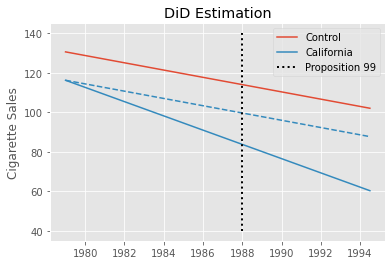

In [6]:
pre_year = data.query("~after_treatment")["year"].mean()
post_year = data.query("after_treatment")["year"].mean()

pre_control_y = did_model.params["Intercept"]
post_control_y = did_model.params["Intercept"] + did_model.params["after_treatment[T.True]"]

pre_treat_y = did_model.params["Intercept"] + did_model.params["treated[T.True]"]

post_treat_y0 = post_control_y + did_model.params["treated[T.True]"]

post_treat_y1 = post_treat_y0 + did_model.params["after_treatment[T.True]:treated[T.True]"]

plt.plot([pre_year, post_year], [pre_control_y, post_control_y], color="C0", label="Control")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y0], color="C1", ls="dashed")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y1], color="C1", label="California")

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.title("DiD Estimation")
plt.ylabel("Cigarette Sales")
plt.legend();

Cette estimation doit cependant être prise avec prudence. Nous savons que la méthode des Doubles Différences exige que la tendance dans le groupe de contrôle soit égale à celle du groupe traité en l'absence de traitement. Formellement, $E[Y(0)_{post, co} - Y(0)_{pre, co}] = E[Y(0)_{post, tr} - Y(0)_{pre, tr}]$. Cette hypothèse est non testable, mais en observant la tendance avant traitement de la Californie (l'unité traitée) et des autres États, nous pouvons avoir une idée de sa plausibilité. Plus précisément, nous pouvons voir que la tendance des ventes de cigarettes (`cigsale`) en Californie n'est pas parallèle à celle des autres États, du moins avant le traitement. Les ventes de cigarettes en Californie diminuent plus rapidement que la moyenne des États de contrôle, même avant le traitement. Si cette tendance se prolonge au-delà de la période avant traitement, l'estimateur DiD sera biaisé vers le bas, ce qui signifie que l'effet réel est en fait moins extrême que celui que nous avons estimé précédemment.

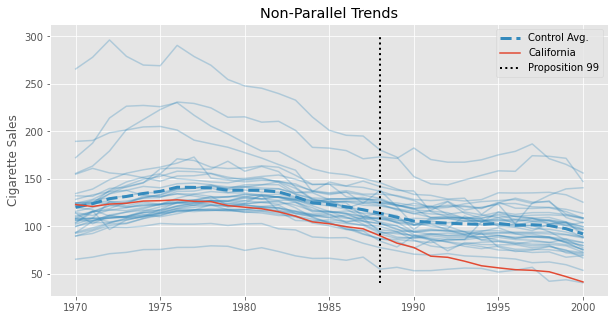

In [7]:
plt.figure(figsize=(10,5))
plt.plot(data_piv.drop(columns=["california"]), color="C1", alpha=0.3)
plt.plot(data_piv.drop(columns=["california"]).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")
plt.plot(data_piv["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Non-Parallel Trends");

Le problème des tendances non parallèles est précisément là où le Contrôle Synthétique entre en jeu dans le modèle des Doubles Différences Synthétiques. Mais n'allons pas trop vite. Que le DiD soit un modèle valide pour les données ci-dessus ou non, ce qui est intéressant, c'est que nous pouvons le reformuler en utilisant la formulation des Effets Fixes Bidirectionnels. Pour cadrer le DiD de cette manière, nous ajustons les moyennes des unités ($\alpha_i$) et des périodes ($\beta_t$), ainsi que l'indicateur de traitement.

$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{argmin} \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$

Dans cette formulation, les effets unitaires capturent la différence d'ordonnées à l'origine pour chaque unité, tandis que les effets temporels capturent la tendance générale à la fois pour les unités traitées et de contrôle. Pour mettre en œuvre cela, nous pourrions soit ajouter des variables indicatrices de temps et d'unité au modèle, soit centrer les données. Dans ce processus, nous soustrayons la moyenne à la fois dans le temps et entre les unités des variables de traitement et de résultat :

$$
\ddot{Y}_{it} = Y_{it} - \bar{Y}_i  - \bar{Y}_t\\
\ddot{D}_{it} = D_{it} - \bar{D}_i - \bar{D}_t
$$

Où $\bar{X}_i$ est la moyenne sur toutes les périodes pour l'unité $i$ et $\bar{X}_t$ est la moyenne sur toutes les unités pour le temps $t$ :

$$
\ddot{Y}_{it} = Y_{it} - T^{-1}\sum_{t=0}^{t=T} Y_{it}  - N^{-1}\sum_{i=0}^{i=N} Y_{it}\\
\ddot{D}_{it} = D_{it} - T^{-1}\sum_{t=0}^{t=T} D_{it} - N^{-1}\sum_{i=0}^{i=N} D_{it}
$$

Après avoir centré les données, une simple régression du résultat sur l'indicateur de traitement (`treat*post`) donne l'estimateur des doubles différences.

In [8]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("state")[col_to_demean].transform("mean")
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

formula = f"""cigsale ~ treat"""
mod = smf.ols(formula,
              data=data
              .assign(treat = data["after_treatment"]*data["treated"])
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="cigsale")))

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-119.1647,0.333,-358.379,0.000,-119.817,-118.512
treat,-27.3491,4.283,-6.385,0.000,-35.753,-18.945


Comme vous pouvez le voir, nous obtenons exactement le même paramètre qu'auparavant. Après tout, les deux approches ne sont que des façons différentes de voir le même estimateur DiD. Cependant, la raison pour laquelle cette formulation est beaucoup plus intéressante pour notre objectif est qu'elle nous permet de voir à quel point le DiD est en réalité assez similaire aux Contrôles Synthétiques. Regardez de très près la formulation des Effets Fixes Bidirectionnels (TWFE) ci-dessus. Remarquez qu'il s'agit d'un problème de régression avec des effets temporels et des effets unitaires. Mais notez qu'il n'y a pas de pondérations dans l'objectif d'optimisation. C'est la principale différence entre les Doubles Différences et les Contrôles Synthétiques, comme nous le verrons bientôt.

## Retour sur les Contrôles Synthétiques

Dans l'estimateur canonique des Contrôles Synthétiques, nous trouvons des pondérations pour les unités (États) qui minimisent la différence entre le résultat avant traitement de l'unité traitée et la moyenne pondérée des résultats avant traitement des unités de contrôle (dans un cadre sans covariables). Nous imposons également que les pondérations soient toutes positives et que leur somme soit égale à un. Pour trouver ces pondérations, nous résolvons le problème d'optimisation suivant :

$$
\hat{w}^{sc} = \underset{w}{\mathrm{argmin}} \ ||\pmb{\bar{y}}_{pre, tr} - \pmb{Y}_{pre, co} \pmb{w}_{co}||^2_2 \\
\text{s.t } \ \sum w_i = 1 \text{ et } \ w_i > 0 \ \forall \ i
$$

où le résultat $\pmb{Y}_{pre, co}$ est une matrice de dimensions $T_{pre}$ par $N_{co}$, où les colonnes représentent les unités et les lignes représentent les périodes de temps. $\pmb{w}_{co}$ est un vecteur colonne de dimensions $N_{co}$ par 1, avec une entrée pour chaque unité. Enfin, $\pmb{\bar{y}}_{pre, tr}$ est un vecteur colonne de dimensions $T_{pre}$ par 1, où chaque entrée est la moyenne temporelle des unités traitées pendant la période avant traitement. C'est pourquoi nous appelons parfois le Contrôle Synthétique une régression horizontale. Dans la plupart des problèmes de régression, les unités sont les lignes de la matrice, mais ici elles sont les colonnes. Ainsi, nous régressons le résultat moyen des unités traitées sur les unités de contrôle.

Une fois que nous avons trouvé les pondérations qui résolvent le problème ci-dessus, nous pouvons les multiplier par les unités de contrôle sur toutes les périodes de temps pour obtenir un contrôle synthétique pour l'unité traitée :

$$
\pmb{y}_{sc} = \pmb{Y}_{co}\hat{\pmb{w}}^{sc}
$$

L'idée ici est que $\pmb{y}_{post, sc}$ est un bon estimateur pour notre résultat potentiel manquant $Y(0)_{post, tr}$. Si c'est le cas, l'ATT est simplement la moyenne de l'unité traitée pendant la période post-traitement moins la moyenne du contrôle synthétique, également pendant la période post-traitement.

$$
\hat{\tau} =  \bar{y}_{post, tr} - \bar{y}_{post, sc}
$$

In [9]:
from sc import SyntheticControl

sc_model = SyntheticControl()

y_co_pre = data.query("~after_treatment").query("~treated").pivot("year", "state", "cigsale")
y_tr_pre = data.query("~after_treatment").query("treated")["cigsale"]

sc_model.fit(y_co_pre, y_tr_pre)
sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="sc_w")

sc = data.query("~treated").pivot("year", "state", "cigsale").dot(sc_weights)

att = data.query("treated")["cigsale"][sc.index > 1988].mean() - sc[sc.index > 1988].mean()

print("SC ATT: ", att.round(4))

SC ATT:  -19.5136


Cette estimation est bien plus faible que celle que nous avons obtenue avec les Doubles Différences. Les Contrôles Synthétiques peuvent mieux s'adapter aux tendances non parallèles avant le traitement, ils ne sont donc pas aussi sensibles au même biais que les Doubles Différences. En effet, le processus de construction d'un Contrôle Synthétique impose des tendances parallèles, du moins pendant la période avant traitement. En conséquence, l'estimation que nous obtenons est beaucoup plus faible et bien plus plausible.

Nous pouvons visualiser ce processus d'estimation en traçant le résultat observé pour la Californie aux côtés du résultat du contrôle synthétique. Nous traçons également sous forme de lignes pointillées la moyenne post-intervention de la Californie et du contrôle synthétique. La différence entre ces lignes représente l'ATT estimé.

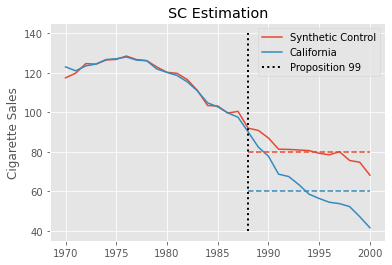

In [10]:
plt.plot(sc, label="Synthetic Control")
plt.plot(sc.index, data.query("treated")["cigsale"], label="California", color="C1")

calif_avg = data.query("treated")["cigsale"][sc.index > 1988].mean()
sc_avg = sc[sc.index > 1988].mean()

plt.hlines(calif_avg, 1988, 2000, color="C1", ls="dashed")
plt.hlines(sc_avg, 1988, 2000, color="C0", ls="dashed")

plt.title("SC Estimation")
plt.ylabel("Cigarette Sales")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend();

Il est intéressant de noter que nous pouvons également reformuler l'estimateur du Contrôle Synthétique comme la résolution du problème d'optimisation suivant, qui est assez similaire à la formulation des Effets Fixes Bidirectionnels que nous avons utilisée pour les Doubles Différences.

$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{argmin}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$

où les pondérations $\hat{w}^{sc}_i$ pour les unités de contrôle sont estimées à partir du problème d'optimisation que nous avons vu précédemment. Pour l'unité traitée, les pondérations sont simplement $1/N_{tr}$ (pondération uniforme).

Remarquez la différence entre le Contrôle Synthétique (SC) et les Doubles Différences (DiD) ici. Premièrement, le Contrôle Synthétique ajoute des pondérations unitaires $\hat{w}^{sc}_i$ à l'équation. Deuxièmement, nous avons des effets fixes temporels $\beta_t$, mais pas d'effet fixe unitaire $\alpha_i$, ni d'intercepte général $\mu$.

Pour vérifier que ces deux formulations sont en réalité équivalentes, voici le code correspondant, qui donne exactement la même estimation de l'ATT.

In [11]:
@curry
def demean_time(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

data_w_cs_weights = data.set_index("state").join(sc_weights).fillna(1/len(sc_weights))

formula = f"""cigsale ~ -1 + treat"""

mod = smf.wls(formula,
              data=data_w_cs_weights
              .assign(treat = data_w_cs_weights["after_treatment"]*data_w_cs_weights["treated"])
              .pipe(demean_time(col_to_demean="treat"))
              .pipe(demean_time(col_to_demean="cigsale")),
              weights=data_w_cs_weights["sc_w"]+1e-10)

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,-19.5136,13.289,-1.468,0.142,-45.586,6.559


Nous venons de voir comment les deux approches, SC (Contrôle Synthétique) et DiD (Doubles Différences), sont en réalité étroitement liées. Nous sommes maintenant prêts à parler du modèle des Doubles Différences Synthétiques. Comme vous pouvez probablement le deviner, il s'agit simplement d'ajouter des pondérations à l'estimateur DiD ou des effets fixes unitaires à l'estimateur du Contrôle Synthétique.

![img](data/img/sdid/both-pills.png)

## Doubles Différences Synthétiques

Avant de plonger directement dans l'estimateur des Doubles Différences Synthétiques, permettez-moi de reproduire les mêmes équations que nous avons vues plus tôt pour SC et DiD, ce qui facilitera la comparaison.

$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{argmin}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$

$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{argmin} \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$

Ensuite, comme promis, nous pouvons facilement fusionner les équations ci-dessus en une seule, qui contiendra des éléments des deux :

$$
\hat{\tau}^{sdid} = \underset{\mu, \alpha, \beta, \tau}{argmin}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \hat{w}^{sdid}_i \hat{\lambda}^{sdid}_t \bigg\}
$$

Comme vous pouvez le voir, nous avons réintroduit les effets fixes unitaires $\alpha_i$. Nous avons également conservé les pondérations unitaires $\hat{w}_i$. Mais il y a une nouveauté, à savoir les pondérations temporelles $\hat{\lambda}_t$. Ne vous inquiétez pas, il n'y a rien de compliqué. Rappelez-vous comment les pondérations unitaires $w_i$ minimisaient la différence entre les unités de contrôle et la moyenne des unités traitées ? En d'autres termes, nous les utilisons pour ajuster la tendance avant traitement des groupes traités et de contrôle. La pondération temporelle fait la même chose, mais pour les périodes. C'est-à-dire qu'elle minimise la différence entre les périodes avant et après traitement pour les unités de contrôle.

$$
\hat{\lambda}^{sdid} = \underset{\lambda}{\mathrm{argmin}} \ ||\bar{\pmb{y}}_{post, co} - (\pmb{\lambda}_{pre} \pmb{Y}_{pre, co} +  \lambda_0)||^2_2 \\
\text{s.t } \ \sum \lambda_t = 1 \text{ et } \ \lambda_t > 0 \ \forall \ t
$$

Encore une fois, $\pmb{Y}_{pre, co}$ est une matrice de dimensions $T_{pre}$ par $N_{co}$ des résultats, où les lignes représentent les périodes de temps et les colonnes représentent les unités. Mais maintenant, $\bar{\pmb{y}}_{post, co}$ est un vecteur ligne de dimensions 1 par $N_{co}$, où chaque entrée est le résultat moyen temporel pour cette unité de contrôle pendant la période post-traitement. Enfin, $\pmb{\lambda}_{pre}$ est un vecteur ligne de dimensions 1 par $T_{pre}$, avec une entrée pour chaque période avant traitement. Une autre façon de voir cela est de noter que les pondérations unitaires $w$ multipliaient la matrice des résultats $\pmb{Y}_{pre, co} \pmb{w}_{co}$. Cela signifie que nous régressions le résultat moyen **pour chaque unité** du groupe traité sur le résultat des unités du groupe de contrôle. Maintenant, nous retournons ce problème, en régressant le résultat moyen **pour chaque période post-traitement** du groupe de contrôle sur le résultat des mêmes unités de contrôle, mais pendant la période avant traitement.

Quant aux pondérations temporelles dans les périodes post-traitement, nous les fixons simplement à un sur le nombre de périodes post-traitement $1/T_{post}$ (encore une fois, en utilisant une pondération uniforme). Remarquez également que nous avons un intercept $\lambda_0$. Nous faisons cela pour permettre à la période post-traitement d'être au-dessus ou en dessous de toutes les périodes avant traitement, ce qui est le cas dans de nombreuses applications avec une tendance clairement positive ou négative.

Si tout cela vous semble un peu abstrait, peut-être que du code vous aidera à comprendre ce qui se passe.

In [12]:
def fit_time_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
        
        control = data.query(f"~{treat_col}")
        
        # pivot the data to the (T_pre, N_co) matrix representation
        y_pre = (control
                 .query(f"~{post_col}")
                 .pivot(year_col, state_col, outcome_col))
        
        # group post-treatment time period by units to have a (1, N_co) vector.
        y_post_mean = (control
                       .query(f"{post_col}")
                       .groupby(state_col)
                       [outcome_col]
                       .mean()
                       .values)
        
        # add a (1, N_co) vector of 1 to the top of the matrix, to serve as the intercept.
        X = np.concatenate([np.ones((1, y_pre.shape[1])), y_pre.values], axis=0)
        
        # estimate time weights
        w = cp.Variable(X.shape[0])
        objective = cp.Minimize(cp.sum_squares(w@X - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        # print("Intercept: ", w.value[0])
        return pd.Series(w.value[1:], # remove intercept
                         name="time_weights",
                         index=y_pre.index)

La première chose que nous faisons dans ce code est de filtrer le groupe traité. Ensuite, nous réorganisons les données avant traitement pour obtenir la matrice $\pmb{Y}_{pre, co}$. Ensuite, nous regroupons les données post-traitement pour obtenir le résultat moyen pour chaque unité de contrôle pendant la période post-traitement. Nous ajoutons ensuite une ligne remplie de 1 en haut de $\pmb{Y}_{pre, co}$, qui servira d'intercept. Enfin, nous régressons $\bar{\pmb{y}}_{post, co}$ sur les périodes avant traitement (les lignes de $\pmb{Y}_{pre, co}$) pour obtenir les pondérations temporelles $\lambda_t$. Remarquez comment nous ajoutons les contraintes pour que les pondérations totalisent 1 et soient non négatives. Enfin, nous éliminons l'intercept et stockons les pondérations temporelles dans une série.

Voici le résultat que nous obtenons en exécutant le code ci-dessus pour trouver les pondérations temporelles dans le cadre du problème de la Proposition 99. Remarquez que toutes les périodes, sauf 1986, 1987 et 1988, obtiennent des pondérations nulles. Cela signifie qu'une moyenne pondérée des trois dernières périodes suffit à équilibrer les périodes avant et après traitement.

In [13]:
time_weights = fit_time_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

time_weights.round(3).tail()

year
1984   -0.000
1985   -0.000
1986    0.366
1987    0.206
1988    0.427
Name: time_weights, dtype: float64

Pour mieux comprendre le rôle de ces pondérations, nous pouvons tracer $\hat{\pmb{\lambda}}_{pre} \pmb{Y}_{pre, co} +  \hat{\lambda}_0$ sous forme d'une ligne horizontale pendant la période avant traitement qui ne s'annule pas. À côté de cela, nous traçons le résultat moyen pendant la période post-traitement. Remarquez comment ils s'alignent parfaitement. Nous affichons également les pondérations temporelles estimées sous forme de barres rouges sur l'axe secondaire.

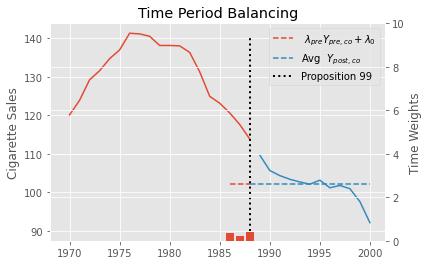

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean())
ax.plot(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean())

intercept = -15.023877689807628
ax.hlines((data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean() * time_weights).sum() - 15, 1986, 1988,
          color="C0", ls="dashed", label=""" $\lambda_{pre} Y_{pre, co} + \lambda_0$""")
ax.hlines(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean().mean(), 1988, 2000,
          color="C1", ls="dashed", label="""Avg  $Y_{post, co}$""")
ax.vlines(x=1988, ymin=90, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()

plt.title("Time Period Balancing")
plt.ylabel("Cigarette Sales");

ax2 = ax.twinx()
ax2.bar(time_weights.index, time_weights, label="$\lambda$")
ax2.set_ylim(0,10)
ax2.set_ylabel("Time Weights");

Maintenant que nous avons appris ce que sont les pondérations temporelles $\lambda_t$ dans l'estimateur des Différences en Différences Synthétiques et comment les estimer, tournons notre attention vers les pondérations unitaires $w_i$. Et non, malheureusement, elles ne sont pas tout à fait comme celles que nous obtenons avec les Contrôles Synthétiques traditionnels. La première différence est que nous autorisons également un intercept $w_0$. Nous faisons cela parce que nous n'avons plus besoin que l'unité traitée et le contrôle synthétique aient le même niveau. Puisque nous allons intégrer DiD dans le mélange, nous avons seulement besoin de rendre les tendances parallèles entre le contrôle synthétique et l'unité traitée.

La prochaine différence est que nous ajoutons une pénalité $L_2$ aux pondérations. Cela aide à répartir les pondérations non nulles sur plusieurs unités de contrôle, au lieu d'avoir seulement quelques-unes d'entre elles contribuant au contrôle synthétique. La pénalité $L_2$ garantit que nous n'ayons pas de pondérations très élevées, ce qui nous oblige à utiliser davantage d'unités.

$$
\hat{w}^{sdid} = \underset{w}{\mathrm{argmin}} \ ||\bar{\pmb{y}}_{pre, tr} - (\pmb{Y}_{pre, co} \pmb{w}_{co} +  w_0)||^2_2 + \zeta^2 T_{pre} ||\pmb{w}_{co}||^2_2\\
\text{s.t } \ \sum w_i = 1 \text{ and } \ w_i > 0 \ \forall \ i
$$

Il y a aussi ce terme $\zeta^2$, qui est théoriquement motivé mais très compliqué à expliquer, donc je vais malheureusement le laisser un peu mystérieux. Dans la référence, vous pouvez consulter l'article original qui les explique. Nous le définissons ainsi :

$$
\zeta = (N_{tr}* T_{post})^{1/4}\sigma(\Delta_{it})
$$

où $\Delta_{it}$ est la première différence dans les résultats $Y_{it} - Y_{i(t-1)}$ et $\sigma(\Delta_{it})$ est l'écart type de cette différence. Voici le code pour le calculer.

In [15]:
def calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    n_treated_post = data.query(post_col).query(treat_col).shape[0]
    
    first_diff_std = (data
                      .query(f"~{post_col}")
                      .query(f"~{treat_col}")
                      .sort_values(year_col)
                      .groupby(state_col)
                      [outcome_col]
                      .diff()
                      .std())
    
    return n_treated_post**(1/4) * first_diff_std

Quant aux pondérations unitaires, il n'y a rien de particulièrement nouveau à leur sujet. Nous pouvons réutiliser une grande partie du code de la fonction utilisée pour estimer les pondérations temporelles. Il suffit simplement de faire attention aux dimensions, car le problème est maintenant inversé.

In [16]:
def fit_unit_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    zeta = calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col)
    pre_data = data.query(f"~{post_col}")
    
    # pivot the data to the (T_pre, N_co) matrix representation
    y_pre_control = (pre_data
                     .query(f"~{treat_col}")
                     .pivot(year_col, state_col, outcome_col))
    
    # group treated units by time periods to have a (T_pre, 1) vector.
    y_pre_treat_mean = (pre_data
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    # add a (T_pre, 1) column to the begining of the (T_pre, N_co) matrix to serve as intercept
    T_pre = y_pre_control.shape[0]
    X = np.concatenate([np.ones((T_pre, 1)), y_pre_control.values], axis=1) 
    
    # estimate unit weights. Notice the L2 penalty using zeta
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X@w - y_pre_treat_mean.values) + T_pre*zeta**2 * cp.sum_squares(w[1:]))
    constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    # print("Intercept:", w.value[0])
    return pd.Series(w.value[1:], # remove intercept
                     name="unit_weights",
                     index=y_pre_control.columns)

Tout d'abord, nous calculons $\zeta$ en utilisant la fonction que nous avons définie précédemment et nous filtrons la période post-traitement. Ensuite, nous réorganisons les données avant traitement pour obtenir la matrice des résultats $\bar{\pmb{y}}_{pre, tr}$. Ensuite, nous ajoutons une colonne remplie de 1 au début de la matrice $\bar{\pmb{y}}_{pre, tr}$. Cette colonne nous permettra d'estimer l'intercept. Avec tout cela en place, nous définissons l'objectif d'optimisation, qui inclut la pénalité $L_2$ sur les pondérations. Enfin, nous éliminons l'intercept et stockons les pondérations estimées dans une série.

Si nous utilisons ce code pour estimer les pondérations unitaires dans le problème de la Proposition 99, voici le résultat que nous obtenons pour les 5 premiers États :

In [17]:
unit_weights = fit_unit_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

unit_weights.round(3).head()

state
1   -0.000
2   -0.000
4    0.057
5    0.078
6    0.070
Name: unit_weights, dtype: float64

Ces pondérations unitaires définissent également un contrôle synthétique que nous pouvons tracer aux côtés du résultat de la Californie. Nous allons également tracer le contrôle synthétique traditionnel que nous avons estimé plus tôt, ainsi que celui que nous venons d'estimer avec le terme d'intercept. Cela nous donnera une meilleure intuition sur ce qui se passe et sur la différence entre ce que nous venons de faire et le Contrôle Synthétique traditionnel.

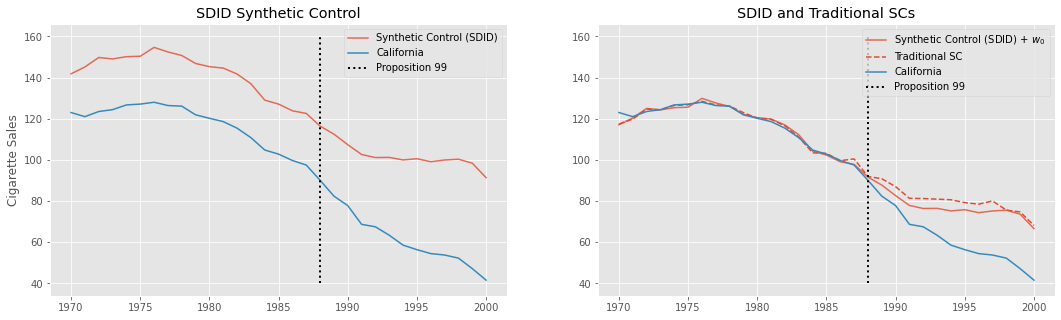

In [18]:
intercept = -24.75035353644767
sc_did = data_piv.drop(columns="california").values @ unit_weights.values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

ax1.plot(data_piv.index, sc_did, label="Synthetic Control (SDID)", color="C0", alpha=.8)
ax1.plot(data_piv["california"], label="California", color="C1")
ax1.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")

ax1.legend()
ax1.set_title("SDID Synthetic Control")
ax1.set_ylabel("Cigarette Sales");

ax2.plot(data_piv.index, sc_did+intercept, label="Synthetic Control (SDID) + $w_0$", color="C0", alpha=.8)
ax2.plot(data_piv.index, sc, label="Traditional SC", color="C0", ls="dashed")
ax2.plot(data_piv["california"], label="California", color="C1")
ax2.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")
ax2.legend()
ax2.set_title("SDID and Traditional SCs");

Comme nous pouvons le voir dans le premier graphique, la différence évidente est que ce nouveau contrôle synthétique n'est plus superposé à celui de la Californie. C'est parce que nous avons inclus un intercept, ce qui permet à l'unité traitée d'être à un niveau arbitrairement différent de son contrôle synthétique. Cette nouvelle méthode de Contrôle Synthétique est construite pour avoir la même tendance avant traitement que l'unité traitée, mais pas nécessairement le même niveau.

Dans le deuxième graphique, nous déplaçons ce nouveau contrôle synthétique en ajoutant l'intercept que nous avions retiré précédemment. Cela le place au même niveau que l'unité traitée, la Californie. Pour comparaison, nous montrons le contrôle synthétique traditionnel que nous avons ajusté précédemment sous forme de ligne pointillée rouge. Remarquez qu'ils ne sont pas identiques. Cette différence provient à la fois du fait que nous avons autorisé un intercept et de la pénalité $L_2$, qui a poussé les pondérations vers zéro.

Maintenant que nous avons à la fois les pondérations temporelles $\hat{\lambda}_t$ et unitaires $\hat{w}_t$, nous pouvons passer à la partie Différences en Différences de l'estimateur des Différences en Différences Synthétiques. Pour cette partie, il est préférable de travailler avec les données sous forme de tableau avec des lignes $N$ par $T$, où nous avons des colonnes pour les États, les années, le résultat, l'indicateur post-traitement et l'indicateur d'unité traitée. À ce tableau, nous allons ajouter les pondérations temporelles et unitaires. Comme les pondérations temporelles sont dans une série indexée par le temps et les pondérations unitaires dans une autre série indexée par les unités, nous pouvons simplement tout fusionner.

In [19]:
def join_weights(data, unit_w, time_w, year_col, state_col, treat_col, post_col):
    return (
        data
        .set_index([year_col, state_col])
        .join(time_w)
        .join(unit_w)
        .reset_index()
        .fillna({time_w.name: 1 / len(pd.unique(data.query(f"{post_col}")[year_col])),
                 unit_w.name: 1 / len(pd.unique(data.query(f"{treat_col}")[state_col]))})
        .assign(**{"weights": lambda d: (d[time_w.name] * d[unit_w.name]).round(10)})
        .astype({treat_col: int, post_col: int}))

Ce processus de fusion laissera des valeurs `null` pour les pondérations unitaires dans le groupe traité et pour les pondérations temporelles dans la période post-traitement. Heureusement, comme nous utilisons des pondérations uniformes dans les deux cas, il est assez facile de remplir ces `null`. Pour les pondérations temporelles, nous les remplissons avec la moyenne de la variable binaire post-traitement, qui sera $1/T_{post}$ ; pour les pondérations unitaires, nous les remplissons avec la moyenne de la variable binaire traitée, qui sera $1/N_{tr}$. Enfin, nous multiplions les deux pondérations ensemble.

Voici le résultat que nous obtenons en exécutant ce code sur les données de la Proposition 99 :

In [20]:
did_data = join_weights(data, unit_weights, time_weights,
                        year_col="year",
                        state_col="state",
                        treat_col="treated",
                        post_col="after_treatment")

did_data.head()

,year,state,cigsale,treated,after_treatment,time_weights,unit_weights,weights
0,1970,1,89.800003,0,0,-4.600034e-14,-1.360835e-16,0.0
1,1971,1,95.400002,0,0,-4.582315e-14,-1.360835e-16,0.0
2,1972,1,101.099998,0,0,-5.274190e-14,-1.360835e-16,0.0
3,1973,1,102.900002,0,0,-5.766356e-14,-1.360835e-16,0.0
4,1974,1,108.199997,0,0,-5.617979e-14,-1.360835e-16,0.0


In [21]:
data["after_treatment"].mean()

0.3870967741935484

In [22]:
1/len(data.query("after_treatment==1")["year"].unique())

0.08333333333333333

Enfin, tout ce qu'il nous reste à faire est d'estimer un modèle de Doubles Différences avec les pondérations que nous venons de définir. L'estimation du paramètre associé au terme d'interaction entre la période post-traitement et la variable binaire traitée sera l'estimation des Doubles Différences Synthétiques pour l'ATT.

In [23]:
did_model = smf.wls("cigsale ~ after_treatment*treated",
                    data=did_data,
                    weights=did_data["weights"]+1e-10).fit()

did_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,120.4060,1.272,94.665,0.000,117.911,122.901
after_treatment,-19.1905,1.799,-10.669,0.000,-22.720,-15.661
treated,-25.2601,1.799,-14.043,0.000,-28.789,-21.731
after_treatment:treated,-15.6054,2.544,-6.135,0.000,-20.596,-10.615


Cette estimation est beaucoup plus faible que celle que nous obtenons avec les Différences en Différences, mais ce n'est pas surprenant. Comme nous l'avons déjà mentionné, l'estimateur DiD est probablement biaisé dans ce cas, car nous avons de bonnes raisons de remettre en question l'hypothèse des tendances parallèles. Ce qui est peut-être moins évident, c'est pourquoi l'estimation SDID est plus faible que l'estimation traditionnelle de SC. Si nous revenons et examinons le graphique SC, nous pouvons voir que les ventes de cigarettes en Californie ont commencé à chuter en dessous de son contrôle synthétique avant la Proposition 99. Cela est probablement dû au fait que le Contrôle Synthétique traditionnel doit faire correspondre les unités traitées et de contrôle sur l'ensemble de la période avant traitement, ce qui peut l'amener à manquer une année ou une autre. Ce problème est moins important dans SDID, car les pondérations temporelles nous permettent de nous concentrer uniquement sur les périodes qui sont plus similaires à la période post-intervention. Dans ce cas, il s'agissait précisément des trois années précédant la Proposition 99.

Pour comprendre ce que fait SDID, nous pouvons tracer les lignes Diff-in-Diff pour l'unité traitée (Californie) et le contrôle synthétique SDID. Remarquez comment nous projetons la tendance que nous voyons dans le contrôle synthétique sur l'unité traitée pour obtenir le contrefactuel $Y(0)_{tr, post}$. La différence entre la ligne pointillée violette et la ligne violette solide inférieure représente l'ATT. Nous commençons ces lignes en 1987 pour montrer comment les pondérations temporelles annulent toutes les périodes sauf 1986, 87 et 88. Les pondérations temporelles sont également montrées dans le petit graphique en bas.

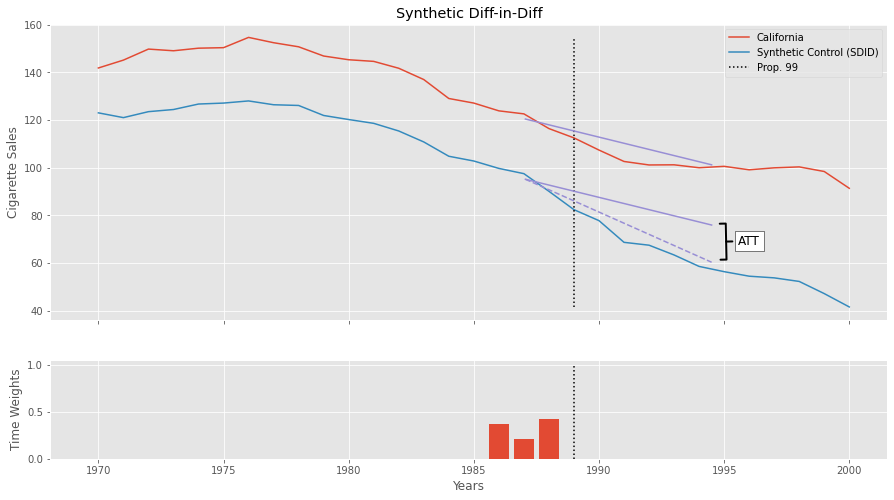

In [24]:
avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = 1989 + (2000 - 1989) / 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(data_piv.index, sc_did, label="California")
ax1.plot(data_piv.index, data_piv["california"], label="Synthetic Control (SDID)")
ax1.vlines(1989, data_piv["california"].min(), sc_did.max(), color="black", ls="dotted", label="Prop. 99")

pre_sc = did_model.params["Intercept"]
post_sc = pre_sc + did_model.params["after_treatment"]
pre_treat = pre_sc + did_model.params["treated"]
post_treat = post_sc + did_model.params["treated"] + did_model.params["after_treatment:treated"]

sc_did_y0 = pre_treat + (post_sc - pre_sc)

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2", ls="dashed")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2")

ax1.annotate('ATT', xy=(1995, 69), xytext=(1996, 66.5), 
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.5', lw=2.0, color='k'))

ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.set_ylabel("Cigarette Sales")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Years");

L'estimateur ci-dessus estime l'ATT, qui est l'effet de la Proposition 99 sur la Californie moyenné sur toutes les périodes post-traitement. Cependant, d'après le graphique précédent, il semble que l'effet augmente au fil du temps. Que faire si nous voulons en tenir compte ? Heureusement, il est très simple de le faire.

Avant de continuer, une mise en garde concernant l'estimateur précédent : vous **ne devriez pas** vous fier aux erreurs standard ou aux intervalles de confiance rapportés par la régression que nous venons de faire. Ils ne reflètent pas la variance dans l'estimation des pondérations. Nous verrons brièvement comment faire une inférence correcte, mais d'abord, voyons comment gérer l'hétérogénéité des effets dans le temps.

## Hétérogénéité des Effets dans le Temps et Adoption Échelonnée

Heureusement, il est extrêmement facile d'estimer un effet pour chaque période temporelle en utilisant SDID. Tout ce que nous avons à faire est de l'exécuter plusieurs fois, une pour chaque période temporelle. Pour être plus précis, disons que nous avons la matrice d'affectation de traitement suivante, avec seulement 4 périodes et 3 unités. La dernière unité est celle traitée.

$$
D = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
    0_4 & 0_4 & 1_4 \\
\end{bmatrix}
$$

L'exécution de SDID avec la matrice ci-dessus nous donnerait l'ATT moyen sur les périodes 3 et 4. Ce que nous pouvons faire pour estimer l'effet sur chaque période individuellement est simplement de diviser le problème en deux, une pour chaque période post-traitement. Ensuite, nous exécutons SDID sur les données où nous ne conservons que la période post-traitement 3, puis à nouveau sur les données où nous ne conservons que la période post-traitement 4. Autrement dit, nous exécutons SDID sur chacune des matrices suivantes individuellement.

$$
D_1 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
\end{bmatrix}
$$

$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_4 & 0_4 & 1_4 \\
\end{bmatrix}
$$

Pour ce faire, il serait préférable de fusionner d'abord toutes les étapes de SDID en une seule fonction. Cela inclut l'estimation des pondérations unitaires et temporelles, ainsi que l'exécution de la méthode DiD.

In [25]:
def synthetic_diff_in_diff(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    # find the unit weights
    unit_weights = fit_unit_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)
    
    # find the time weights
    time_weights = fit_time_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)

    # join weights into DiD Data
    did_data = join_weights(data, unit_weights, time_weights,
                            year_col=year_col,
                            state_col=state_col,
                            treat_col=treat_col,
                            post_col=post_col)
    
    # run DiD
    formula = f"{outcome_col} ~ {post_col}*{treat_col}"
    did_model = smf.wls(formula, data=did_data, weights=did_data["weights"]+1e-10).fit()
    
    return did_model.params[f"{post_col}:{treat_col}"]


synthetic_diff_in_diff(data, 
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

-15.605397234587002

Maintenant que nous avons un moyen de faire tourner SDID facilement, nous pouvons l'exécuter plusieurs fois en filtrant toutes les périodes post-traitement sauf celle pour laquelle nous voulons estimer l'effet. Cela nous permet d'obtenir une estimation de l'effet spécifique à chaque période post-traitement, en tenant compte de l'hétérogénéité des effets dans le temps.

In [26]:
effects = {year: synthetic_diff_in_diff(data.query(f"~after_treatment|(year=={year})"), 
                                        outcome_col="cigsale",
                                        year_col="year",
                                        state_col="state",
                                        treat_col="treated",
                                        post_col="after_treatment")
           for year in range(1989, 2001)}

effects = pd.Series(effects)

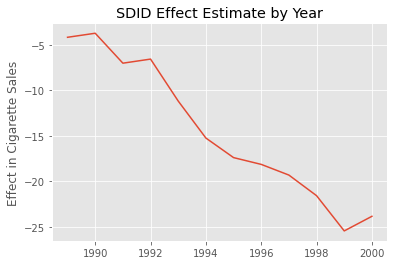

In [27]:
plt.plot(effects);
plt.ylabel("Effect in Cigarette Sales")
plt.title("SDID Effect Estimate by Year");

Comme prévu, l'effet devient plus important au fil du temps. Il commence de manière modeste, mais augmente progressivement jusqu'à une réduction apparente de 25 paquets de cigarettes par habitant en 2020.

Convenablement, exécuter plusieurs SDID sera également important pour traiter les cas d'adoption échelonnée. Avec un design d'adoption échelonnée, nous avons plusieurs unités traitées, qui reçoivent le traitement à des périodes différentes. Par exemple, en revenant à notre matrice d'affectation très simple, avec 3 unités et 4 périodes, supposons que l'unité 1 ne reçoit jamais le traitement, l'unité 2 le reçoit à la période 4 et l'unité 3 à la période 3. Cela donnerait la matrice suivante :

$$
D = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
    0_4 & 1_4 & 1_4 \\
\end{bmatrix}
$$

Remarquez que SDID ne peut pas gérer cette matrice, car nous n'avons pas de définition claire de ce qu'est une période avant traitement (avant la période 4 pour l'unité 2 ou avant la période 3 pour l'unité 3) ou de ce qu'est une unité de contrôle (l'unité 2 pourrait être un contrôle pour le traitement commençant à la période 3). La clé pour résoudre ce problème est de réaliser que nous pouvons supprimer des colonnes (unités) ou des lignes (périodes) dans cette matrice afin de revenir à un design de blocs.

Par exemple, nous pouvons créer deux matrices de blocs à partir de celle-ci en supprimant d'abord la 3e période, puis en créant une autre où nous supprimons la 4e période.

$$
D_1 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_4 & 1_4 & 1_4 \\
\end{bmatrix}
$$

$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
\end{bmatrix}
$$

Le résultat est deux matrices de blocs, ce qui signifie que nous pouvons exécuter SDID sur chacune d'elles. Le résultat sera deux estimations de l'ATT, que nous pourrons ensuite combiner avec une moyenne pondérée, où les poids correspondent à la proportion de temps traité et de périodes dans chaque bloc. Dans notre exemple, le poids pour $ATT_1$ serait $2/3$ et le poids pour $ATT_2$ serait $1/3$.

Alternativement, nous pourrions également avoir deux designs de blocs en supprimant des colonnes, ce qui donnerait les matrices suivantes :

$$
D_1 = \begin{bmatrix}
    0_1 & 0_1  \\
    0_2 & 0_2  \\
    0_3 & 0_3  \\
    0_4 & 1_4  \\
\end{bmatrix}
$$

$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 \\
    0_2 & 0_2 \\
    0_3 & 1_3 \\
    0_4 & 1_4 \\
\end{bmatrix}
$$

où $D_1$ comprend les unités 1 et 2, et $D_2$ comprend les unités 1 et 3.

Puisque nous avons déjà vu comment estimer SDID pour différentes périodes temporelles, regardons cette approche où nous filtrons les unités. Comme nous n'avons pas initialement un design d'adoption échelonnée dans nos données sur la Proposition 99, simulons-en un à la place. Nous allons créer trois nouveaux États à partir de nos données et supposer qu'ils adoptent une loi similaire à la Proposition 99, mais en 1993. Peut-être ont-ils été impressionnés par les résultats en Californie et ont voulu essayer dans leurs États aussi. Une fois cette loi adoptée, la consommation de cigarettes diminue de 3 % chaque année. Nous pouvons visualiser la consommation moyenne de cigarettes dans ces nouveaux États pour mieux comprendre ce qui se passe. En noir pointillé, nous indiquons l'année où ces États adoptent cette loi anti-tabac.

In [28]:
np.random.seed(1)
n = 3
tr_state = (data
            .query(f"state.isin({list(np.random.choice(data['state'].unique(), n))})")
            .assign(**{
                "treated": True,
                "state": lambda d: "new_" + d["state"].astype(str),
                "after_treatment": lambda d: d["year"] > 1992
            })
            # effect of 3% / year
            .assign(**{"cigsale": lambda d: np.random.normal(d["cigsale"] - 
                                                             d["cigsale"]*(0.03*(d["year"] - 1992))*d["after_treatment"], 1)}))

new_data = pd.concat([data, tr_state]).assign(**{"after_treatment": lambda d: np.where(d["treated"], d["after_treatment"], False)})

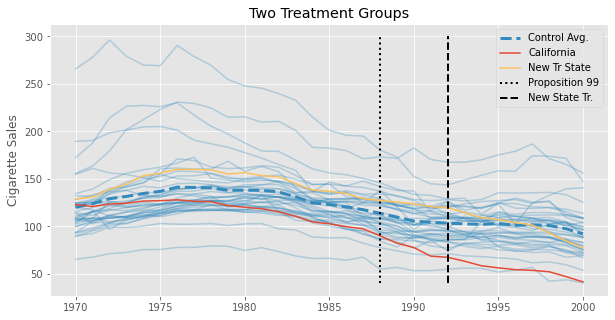

In [29]:
new_data_piv = new_data.pivot("year", "state", "cigsale")

new_tr_states = list(filter(lambda c: str(c).startswith("new"), new_data_piv.columns))

plt.figure(figsize=(10,5))
plt.plot(new_data_piv.drop(columns=["california"]+new_tr_states), color="C1", alpha=0.3)
plt.plot(new_data_piv.drop(columns=["california"]+new_tr_states).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")

plt.plot(new_data_piv["california"], color="C0", label="California")
plt.plot(new_data_piv[new_tr_states].mean(axis=1), color="C4", label="New Tr State")

plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.vlines(x=1992, ymin=40, ymax=300, linestyle="dashed", lw=2, label="New State Tr.", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Two Treatment Groups");

Maintenant que nous avons ces données d'adoption échelonnée, nous devons déterminer comment filtrer certains États afin de diviser le problème en plusieurs cas d'affectation par bloc. Tout d'abord, nous pouvons regrouper les États en fonction de la date à laquelle ils ont adopté la loi. Le code suivant fait exactement cela :

In [30]:
assignment_blocks = (new_data.query("treated & after_treatment")
                     .groupby("state")["year"].min()
                     .reset_index()
                     .groupby("year")["state"].apply(list).to_dict())

assignment_blocks

{1989: ['california'], 1993: ['new_13', 'new_38', 'new_9']}

Comme vous pouvez le voir, nous avons deux groupes d'États. Un avec uniquement la Californie, qui a été traitée à partir de 1989, et un autre avec les trois nouveaux États que nous avons créés, qui ont tous été traités à partir de 1993. Maintenant, nous devons exécuter SDID pour chacun de ces groupes. Nous pouvons le faire facilement en ne conservant que les unités de contrôle plus l'un de ces groupes. Cependant, il y a un détail important à prendre en compte : la colonne `after_treatment` aura une signification différente selon le groupe que nous examinons. Si nous regardons le groupe contenant uniquement la Californie, `after_treatment` doit être défini comme `year >= 1989`. Si nous regardons le groupe avec les nouveaux États, il doit être défini comme `year >= 1993`. Heureusement, cela est assez facile à gérer. Il suffit de recréer la colonne `after_treatment` à chaque itération.

In [31]:
staggered_effects = {year: synthetic_diff_in_diff(new_data
                                                   .query(f"~treated|(state.isin({states}))")
                                                   .assign(**{"after_treatment": lambda d: d["year"] >= year}),
                                                  outcome_col="cigsale",
                                                  year_col="year",
                                                  state_col="state",
                                                  treat_col="treated",
                                                  post_col="after_treatment")
                     for year, states in assignment_blocks.items()}

staggered_effects

{1989: -15.605397234587002, 1993: -17.249435402003648}

Sans surprise, l'estimation de $ATT$ pour le premier groupe, celui qui ne comprend que la Californie, est exactement la même que celle que nous avons vue auparavant. L'autre $ATT$ fait référence à celui que nous obtenons avec le nouveau groupe d'États. Nous devons les combiner en un seul $ATT$. Cela peut être fait avec la moyenne pondérée que nous avons expliquée plus tôt.

Tout d'abord, nous calculons le nombre d'entrées traitées (`après_traitement & traité`) dans chaque bloc. Ensuite, nous combinons les $ATT$ en utilisant ces pondérations.

In [32]:
weights = {year: sum((new_data["year"] >= year) & (new_data["state"].isin(states)))
           for year, states in assignment_blocks.items()}

att = sum([effect*weights[year]/sum(weights.values()) for year, effect in staggered_effects.items()])

print("weights: ", weights)
print("ATT: ", att)

weights:  {1989: 12, 1993: 24}
ATT:  -16.701422679531433


Ici, nous avons un total de 36 instances de traitement : les 12 périodes post-traitement habituelles pour la Californie, plus 8 périodes de traitement (1993-2000) pour chacun des trois nouveaux États traités que nous avons introduits. Avec cela en tête, le poids pour le premier $ATT$ est $12/36$, et pour le second $ATT$, $24/36$, ce qui conduit au résultat mentionné ci-dessus.

## Estimation de la Variance de Placebo

Ce chapitre commence à être un peu trop long, mais il y a une promesse que nous n'avons pas encore tenue. Rappelez-vous comment nous avons dit, au tout début, que SDID offre une meilleure précision (des barres d'erreur plus faibles) par rapport aux Contrôles Synthétiques ? La raison en est que les effets fixes de temps et d'unité dans SDID capturent une grande partie de la variation dans le résultat, ce qui réduit à son tour la variance de l'estimateur.

Bien sûr, je ne vous demanderais pas de me croire sur parole, donc ensuite, nous allons montrer comment placer un intervalle de confiance autour de l'estimation SDID. Il s'avère qu'il existe de nombreuses solutions à ce problème, mais une seule correspond au cas d'une unité traitée unique, ce qui est le cas ici puisque seule la Californie a été traitée. L'idée est de réaliser une série de tests de placebo, où nous prétendons qu'une unité du groupe de contrôle est traitée, alors qu'elle ne l'est pas. Ensuite, nous utilisons SDID pour estimer le $ATT$ de ce test de placebo et nous stockons son résultat. Nous réexécutons cette étape plusieurs fois, en échantillonnant une unité de contrôle à chaque fois. À la fin, nous aurons un ensemble de $ATT$s de placebo. La variance de cet ensemble est la variance de placebo de l'estimation de l'effet SDID, que nous pouvons utiliser pour construire un intervalle de confiance.

$$
\hat{V}^{placebo}_{\tau} = B^{-1}\sum_{b=1}^B\bigg(\hat{\tau}^{(b)} - \bar{\hat{\tau}}^{(b)}\bigg)^2
$$

$$
\tau \in \hat{\tau}^{sdid} \pm \mathcal{z}_{\alpha/2} \sqrt{\hat{V}_{\tau}}
$$

Pour implémenter cela, la première chose dont nous avons besoin est une fonction qui crée le placebo. Cette fonction filtrera les unités traitées, échantillonnera une seule unité de contrôle et changera la colonne `traité` de cette unité de contrôle de 0 à 1.

In [33]:
def make_random_placebo(data, state_col, treat_col):
    control = data.query(f"~{treat_col}")
    states = control[state_col].unique()
    placebo_state = np.random.choice(states)
    return control.assign(**{treat_col: control[state_col] == placebo_state})

In [34]:
np.random.seed(1)
placebo_data = make_random_placebo(data, state_col="state", treat_col="treated")

placebo_data.query("treated").tail()

,state,year,cigsale,treated,after_treatment
1204,39,1996,110.300003,True,True
1205,39,1997,108.800003,True,True
1206,39,1998,102.900002,True,True
1207,39,1999,104.800003,True,True
1208,39,2000,90.500000,True,True


Dans l'exemple ci-dessus, nous avons échantillonné l'État 39 et nous prétendons maintenant qu'il a été traité. Remarquez comment la colonne `traité` a été changée en `True`.

La prochaine étape consiste à calculer l'estimation SDID avec ces données de placebo et à répéter cela plusieurs fois. La fonction suivante s'en charge. Elle exécute la fonction `synthetic_diff_in_diff` pour obtenir l'estimation SDID, mais au lieu de passer les données habituelles, nous passons le résultat de l'appel à `make_random_placebo`. Nous répétons cette opération plusieurs fois pour obtenir un ensemble d'estimations SDID et, enfin, nous calculons la racine carrée de la variance de cet ensemble, ce qui correspond à l'écart-type.

In [35]:
from joblib import Parallel, delayed # for parallel processing


def estimate_se(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, seed=0, njobs=4):
    np.random.seed(seed=seed)
    
    sdid_fn = partial(synthetic_diff_in_diff,
                      outcome_col=outcome_col,
                      year_col=year_col,
                      state_col=state_col,
                      treat_col=treat_col,
                      post_col=post_col)
    
    effects = Parallel(n_jobs=njobs)(delayed(sdid_fn)(make_random_placebo(data, state_col=state_col, treat_col=treat_col))
                                     for _ in range(bootstrap_rounds))
    
    return np.std(effects, axis=0)


In [36]:
effect = synthetic_diff_in_diff(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")


se = estimate_se(data,
                 outcome_col="cigsale",
                 year_col="year",
                 state_col="state",
                 treat_col="treated",
                 post_col="after_treatment")

L'écart-type peut ensuite être utilisé pour construire des intervalles de confiance, comme nous l'avons décrit dans la formule ci-dessus.

In [37]:
print(f"Effect: {effect}")
print(f"Standard Error: {se}")
print(f"90% CI: ({effect-1.65*se}, {effect+1.65*se})")

Effect: -15.605397234587002
Standard Error: 9.912089736240311
90% CI: (-31.960345299383516, 0.7495508302095111)


Remarquez que l'$ATT$ n'est pas significatif dans ce cas, mais ce qui est plus intéressant ici, c'est de comparer l'erreur standard de l'estimation SDID avec celle que nous obtenons à partir du Contrôle Synthétique traditionnel.

In [38]:
def synthetic_control(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    x_pre_control = (data
                     .query(f"~{treat_col}")
                     .query(f"~{post_col}")
                     .pivot(year_col, state_col, outcome_col)
                     .values)
    
    y_pre_treat_mean = (data
                        .query(f"~{post_col}")
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    w = cp.Variable(x_pre_control.shape[1])
    objective = cp.Minimize(cp.sum_squares(x_pre_control@w - y_pre_treat_mean.values))
    constraints = [cp.sum(w) == 1, w >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    sc = (data
          .query(f"~{treat_col}")
          .pivot(year_col, state_col, outcome_col)
          .values) @ w.value
    
    y1 = data.query(f"{treat_col}").query(f"{post_col}")[outcome_col]
    att = np.mean(y1 - sc[-len(y1):])
    
    return att


def estimate_se_sc(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, seed=0):
    np.random.seed(seed=seed)
    effects = [synthetic_control(make_random_placebo(data, state_col=state_col, treat_col=treat_col), 
                                 outcome_col=outcome_col,
                                 year_col=year_col,
                                 state_col=state_col,
                                 treat_col=treat_col,
                                 post_col=post_col)
              for _ in range(bootstrap_rounds)]
    
    return np.std(effects, axis=0)


effect_sc = synthetic_control(data,
                              outcome_col="cigsale",
                              year_col="year",
                              state_col="state",
                              treat_col="treated",
                              post_col="after_treatment")


se_sc = estimate_se_sc(data,
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

In [39]:
print(f"Effect: {effect_sc}")
print(f"Standard Error: {se_sc}")
print(f"90% CI: ({effect_sc-1.65*se_sc}, {effect_sc+1.65*se_sc})")

Effect: -19.513629763998537
Standard Error: 11.2419349486209
90% CI: (-38.06282242922302, -0.9644370987740523)


Remarquez comment l'erreur pour le Contrôle Synthétique est plus élevée que pour le SDID. Encore une fois, cela s'explique par le fait que le SDID capture une grande partie de la variance dans le résultat grâce à ses effets fixes de temps et d'unité. Avec cela, nous tenons la promesse que nous avons faite plus tôt. Cependant, avant de conclure, il est important de mentionner que nous pouvons également utiliser la même procédure d'estimation de la variance pour construire un intervalle de confiance autour de l'effet que nous avons estimé pour chaque période post-traitement. Tout ce que nous devons faire est d'exécuter le code ci-dessus une fois pour chaque période. Il est simplement important de garder à l'esprit que cela pourrait prendre un certain temps, même avec la parallélisation que nous avons mise en place.

In [40]:
standard_errors = {year: estimate_se(data.query(f"~after_treatment|(year=={year})"), 
                                     outcome_col="cigsale",
                                     year_col="year",
                                     state_col="state",
                                     treat_col="treated",
                                     post_col="after_treatment")
                   for year in range(1989, 2001)}

standard_errors = pd.Series(standard_errors)

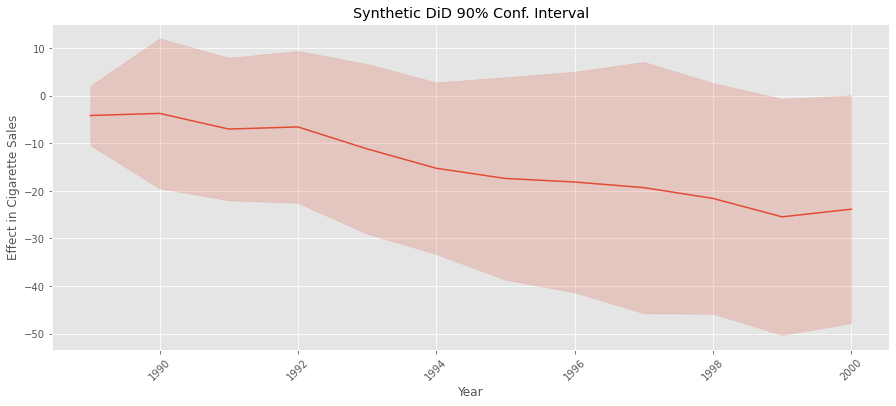

In [41]:
plt.figure(figsize=(15,6))

plt.plot(effects, color="C0")
plt.fill_between(effects.index, effects-1.65*standard_errors, effects+1.65*standard_errors, alpha=0.2,  color="C0")

plt.ylabel("Effect in Cigarette Sales")
plt.xlabel("Year")
plt.title("Synthetic DiD 90% Conf. Interval")
plt.xticks(rotation=45);

## Concepts Clés

Le Synthetic-Diff-in-Diff (SDID) s'inspire à la fois du Diff-in-Diff et du Contrôle Synthétique, apportant ainsi des avantages issus des deux modèles. Comme le SC, le SDID fonctionne avec plusieurs périodes lorsque les tendances pré-traitement ne sont pas parallèles. Cependant, contrairement au SC, le SDID estime des pondérations pour les unités afin de construire une unité de contrôle qui est uniquement parallèle au groupe traité (sans nécessairement en correspondre au niveau). Du DID, le SDID tire parti des effets fixes de temps et d'unité, ce qui aide à expliquer une grande partie de la variance dans le résultat, réduisant ainsi la variance de l'estimateur SDID. Le Synthetic-Diff-in-Diff introduit également quelques nouvelles idées propres. Tout d'abord, il y a une pénalité supplémentaire $L2$ dans l'optimisation des pondérations des unités, ce qui les répartit davantage entre les unités de contrôle. Deuxièmement, le SDID permet un intercept (et donc une extrapolation) lors de la construction de ces pondérations. Troisièmement, le SDID introduit l'utilisation de pondérations temporelles, absentes à la fois dans DID et SC. Pour cette raison, je ne dirais pas que le SDID fusionne simplement SC et DID. Il construit plutôt quelque chose de nouveau, inspiré par ces deux approches. Je ne dirais pas non plus que le SDID est meilleur ou pire que le Contrôle Synthétique traditionnel. Chacun d'eux a des propriétés différentes qui peuvent être appropriées ou non, selon la situation. Par exemple, vous pourriez vous retrouver dans une situation où autoriser les extrapolations du SDID est risqué. Dans ce cas, le SC pourrait être une bonne alternative.

## Références

Ce chapitre est essentiellement une explication de l'article *Synthetic Difference in Differences* (2019), par Dmitry Arkhangelsky, Susan Athey, David A. Hirshberg, Guido W. Imbens et Stefan Wager. De plus, j'aimerais reconnaître Masa Asami pour son implémentation en Python du SDID, pysynthdid. Son code m'a aidé à m'assurer qu'il n'y avait pas de bogues dans le mien, ce qui a été extrêmement utile.
 
 
## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).